load all images into an array. decode meta data from image file names

In [1]:
import os
from PIL import Image
from distutils.util import strtobool

# Directory containing BMP files
directory = 'raw/resistorarray'

# List to store loaded images
images = []
metadata = []
ids = []
states = []
delays = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.bmp'):
        # Load image and append to list
        img = Image.open(os.path.join(directory, filename))
        images.append(img)
        #print(filename)
        id_,state_,delay_ = filename.split("-")
        #print(state_)
        metadatum = {"id":int(id_), "state":strtobool(state_), "delay":float(delay_[:-4])}
        #print(metadatum)
        ids.append(metadatum["id"])
        states.append(metadatum["state"])        
        delays.append(metadatum["delay"])
        #break

# Now 'images' contains all the loaded BMP files
print(f"Loaded {len(images)} BMP files.")

Loaded 1864 BMP files.


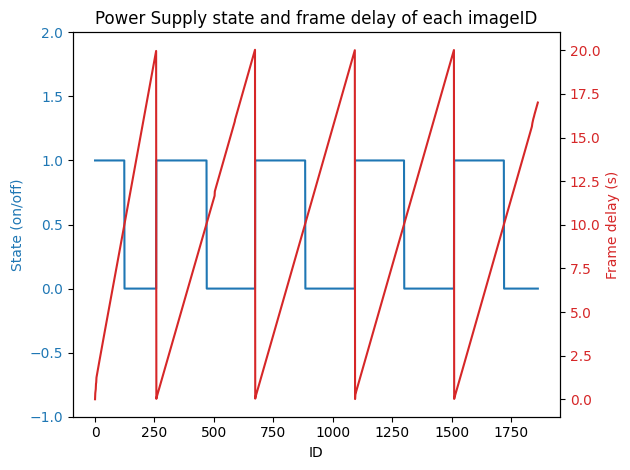

In [2]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
# Add title and labels
plt.title('Power Supply state and frame delay of each imageID')

color = 'tab:blue'

ax1.set_xlabel('ID')
ax1.set_ylabel('State (on/off)', color=color)
ax1.plot(ids, states, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-1, 2])

color = 'tab:red'
ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.set_ylabel('Frame delay (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(ids, delays, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

frame 123 seems to be the begin of the first cicle, 331 the last = 208 frames per cycle = 104 is a resonable diff

Lets inspect each frame from the raw data. If PS (Power Supply) equals 1, then the current is flowing

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interact

%matplotlib inline
@interact(frame=(0,len(images)-1))
#@interact(f, frame=widgets.IntSlider(min=-10, max=30, step=1, value=10))
def f(frame=127):
    ax = plt.imshow(images[frame], label=frame)

    # Create a custom legend
    legend_patches = [
        mpatches.Patch(color='purple', label="PS on: "+ str(states[frame])),
        mpatches.Patch(color='yellow', label='Delay: ' + "{:2.2f}".format(delays[frame])+'s')
    ]    
    # Add the legend to the plot
    plt.legend(handles=legend_patches, loc='upper right', title='Image stats')

interactive(children=(IntSlider(value=127, description='frame', max=1863), Output()), _dom_classes=('widget-in…

Lets do some calculations: We show the raw images, we show difference images by subtracting a background image (when the power supply is off) from a live image when the power supplay is on
We can see that the spot we are interested in, shows at a delay for around 2s of the 10s interval, so 2s/10s = 0.2 which makes a signa phase of 0.2*360° = 72°

In [4]:
from PIL import Image, ImageChops   
on_off_offset = 104 # each cycle is 208 frames long
start_first_interval = 123

%matplotlib inline
@interact(frame=(0,len(images)-1-on_off_offset))
#@interact(f, frame=widgets.IntSlider(min=-10, max=30, step=1, value=10))
def f(frame=127):
    f, axarr = plt.subplots(2,1, figsize=(10,10)) 
    # raw frames
    axarr[0].imshow(images[frame], label=frame)    
    #axarr[2] = plt.imshow(images[frame], label=frame)
    #axarr[3] = plt.imshow(images[frame], label=frame)

    # Create a custom legend for the frames
    legend_patches = [
        mpatches.Patch(label="PS on: "+ str(states[frame])),
        mpatches.Patch(label='Delay: ' + "{:2.2f}".format(delays[frame])+'s')
    ]    
    # Add the legend to the plot
    axarr[0].legend(handles=legend_patches, loc='upper right', title='Raw frames')

    # difference frames     
    diffimg = ImageChops.subtract(images[frame], images[frame+on_off_offset])
    axarr[1].imshow(diffimg, label=frame)

    # Create a custom legend for the frames
    legend_patches = [
        mpatches.Patch(label="Signal image "+ str(frame)),
        mpatches.Patch(label="Background image "+str(frame+on_off_offset)),
        mpatches.Patch(label="PS on: "+ str(states[frame])) 
    ]    
    # Add the legend to the plot
    axarr[1].legend(handles=legend_patches, loc='upper right', title='Difference Image')

interactive(children=(IntSlider(value=127, description='frame', max=1759), Output()), _dom_classes=('widget-in…

Okay, we have a simple subtraction of 2 frames above.
Now lets integrate over all frames.
Strategy: 
  * Add all frames from the PS=1 period
  * Add all frames from the PS=0 period
  * Subtract

Since we are dealing with a phase shift (probably, since the signal response to activating the power supply seems to be shifted by ~70°), we can update your integration function to sum accordingly.
Lets put that to a test and provide a slide for that to adjust to the phase shift
[1] Formular 2.2 in https://beckassets.blob.core.windows.net/product/readingsample/292043/9783642024160_excerpt_001.pdf

In [23]:
import numpy as np

on_off_offset = 104 
start_first_interval = 208
start_2nd_interval = 674
start_last_interval = 1511
start_2nd_interval = start_last_interval # inegrate over 4 intervals
# each cycle is 466 frames long
length_cycle = start_2nd_interval - start_first_interval
phase_offset = 0 
max_ps_on_delay = 20 # important value: phase offset looks at the delay value of each frame to decide if positive or negative weighting

%matplotlib inline
@interact(phase_offset=(0,360))
#@interact(f, frame=widgets.IntSlider(min=-10, max=30, step=1, value=10))
def f(phase_offset=0):
    f, axarr = plt.subplots(2,1, figsize=(10,10)) 
    # raw frames
    frame=start_first_interval
    axarr[0].imshow(images[frame], label=frame)    
    #axarr[2] = plt.imshow(images[frame], label=frame)
    #axarr[3] = plt.imshow(images[frame], label=frame)

    # Create a custom legend for the frames
    legend_patches = [
        mpatches.Patch(label="PS on: "+ str(states[frame])),
        mpatches.Patch(label='Delay: ' + "{:2.2f}".format(delays[frame])+'s')
    ]    
    # Add the legend to the plot
    axarr[0].legend(handles=legend_patches, loc='upper right', title='Raw frames')

    # integration
    # image_count = 1
    # np_integrated_image = np.array(images[start_first_interval])
    # for i in range(start_first_interval, start_2nd_interval-(length_cycle//2)):
    #     np_integrated_image = np_integrated_image+np.array(images[i])
    #     image_count += 1

    # intimg = np_integrated_image/image_count # ImageChops.subtract(images[frame], images[frame+on_off_offset])
    
    #alternate strat

    # calculate the weighting factor based on the phase offset
    in_phase_min_delay_seconds = phase_offset/360*max_ps_on_delay # e.g. for 20s cycle and phase_offset of 90 -> 5s
    in_phase_max_delay_seconds = (in_phase_min_delay_seconds+0.5*max_ps_on_delay) % max_ps_on_delay # assuming a 50% duty cycle -> 15s
    
    
    weights = []
    for i, d in enumerate(delays):
        if in_phase_min_delay_seconds<in_phase_max_delay_seconds:
            if in_phase_min_delay_seconds <= d < in_phase_max_delay_seconds:
                weights.append(1) 
            else:
                weights.append(-1) 
        else: # for phase larger than 180°
            if in_phase_max_delay_seconds <= d < in_phase_min_delay_seconds:
                weights.append(-1) 
            else:
                weights.append(+1)             
    
    # lets convert the images to np array with weighting factor based on PS on and phase
    images_np = []
    for i, im in enumerate(images):
        images_np.append(np.array(im)*weights[i])
    
    # np_integrated_image_stack = np.stack(images_np[start_first_interval:start_2nd_interval-(length_cycle//2)])
    np_integrated_image_stack = np.stack(images_np[start_first_interval:start_2nd_interval])
    intimg = np.mean(np_integrated_image_stack, axis=0)

    image_count = np_integrated_image_stack.shape[0]
        

    axarr[1].imshow(intimg, label=frame)

    # Create a custom legend for the frames
    legend_patches = [
        mpatches.Patch(label="Phase "+ str(phase_offset)+"°"),
        mpatches.Patch(label="Inphase frame delay from: "+ "{:2.1f}".format(in_phase_min_delay_seconds)+'s to: '+"{:2.1f}".format(in_phase_max_delay_seconds)+'s'),
        mpatches.Patch(label="Image Count "+ str(image_count)),
        #mpatches.Patch(label="Background image "+str(frame+on_off_offset)),
        #mpatches.Patch(label="PS on: "+ str(states[frame])) 
    ]    
    # Add the legend to the plot
    axarr[1].legend(handles=legend_patches, loc='upper right', title='Integration Image')

interactive(children=(IntSlider(value=0, description='phase_offset', max=360), Output()), _dom_classes=('widge…